In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
def plot(data, ax, title):
    colors = ['red', 'green', 'blue', 'yellow']

    for i in range(len(data)):
        ax.scatter(data[i][0], data[i][1], color=colors[i], alpha=0.5)
        ax.set_title(title)


def load_data(directory, num_classes, delimiter=','):
    data = []
    for i in range(1, num_classes + 1):
        d = pd.read_csv(f'{directory}/class{i}.txt', header=None, delimiter=delimiter)
        data.append(d)
        d['class'] = i - 1
    
    data.append(pd.concat(data).reset_index(drop=True))
    return tuple(data)

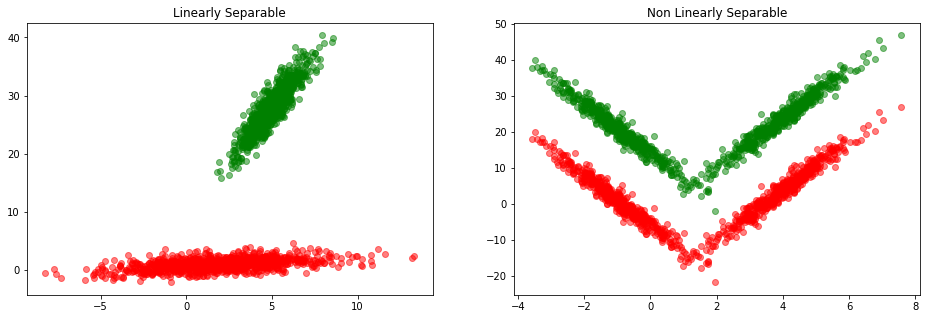

In [3]:
ls_c1, ls_c2, ls = load_data('ls_data', 2)
nls_c1, nls_c2, nls = load_data('nls_data', 2)

fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot((ls_c1, ls_c2), ax[0], "Linearly Separable")
plot((nls_c1, nls_c2), ax[1], "Non Linearly Separable")

In [4]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.drop('class', axis = 1)
    y = data['class']
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    
    return (x_train, x_test, y_train, y_test)

ls_x_train, ls_x_test, ls_y_train, ls_y_test = split_data(ls)
nls_x_train, nls_x_test, nls_y_train, nls_y_test = split_data(nls)

ls_x_train = ls_x_train.to_numpy()
ls_x_test = ls_x_test.to_numpy()

nls_x_train = nls_x_train.to_numpy()
nls_x_test = nls_x_test.to_numpy()

In [5]:
class HistClassifier:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
    
    
    def fit(self, X, y):
        counts = y.value_counts().sort_index(ascending=True)
        self.classes = np.asarray(counts.keys())
        self.class_counts = counts.values
        self.num_classes = len(self.classes)
        self.n_cols = X.shape[1]
        
        class_separated_X = []
        for cls in self.classes:
            class_separated_X.append(X[np.where(y == cls)])
            

        self.hist = []
        self.bins = []

        for cls in self.classes:
            hist = []
            bins = []
            for col in range(self.n_cols):
                h, b = np.histogram(class_separated_X[cls][:, col], self.n_bins, density=True)
                hist.append(h)
                bins.append(b)
            self.hist.append(hist)
            self.bins.append(bins)
        
        self.hist = np.array(self.hist)
        self.bins = np.array(self.bins)

    
    def predict(self, X):
        pred = np.zeros(len(X))
        for i in range(len(X)):
            x = X[i]
            mx_prob = -1
            mx_cls = -1
            for cls in self.classes:
                curr_bins = self.calculate_bins_(x)
                prob = 1
                for col in range(self.n_cols):
                    prob *= self.hist[cls][col][curr_bins[cls][col]]
                
                if (prob > mx_prob):
                    mx_prob = prob
                    mx_cls = cls

            pred[i] = mx_cls
        return pred
                
    def calculate_bins_(self, x):
        bins = []
        for cls in self.classes:
            col_bins = []
            for col in range(self.n_cols):
                flag = True
                for b in range(self.n_bins):
                    if (x[col] >= self.bins[cls][col][b] and x[col] < self.bins[cls][col][b + 1]):
                        col_bins.append(b)
                        flag = False
                        break;
                if (flag):
                    col_bins.append(self.n_bins - 1)
            bins.append(col_bins)
        
        return bins


In [6]:
clf = HistClassifier(15)

clf.fit(ls_x_train, ls_y_train)

In [7]:
pred = clf.predict(ls_x_test)

In [8]:
from sklearn.metrics import confusion_matrix

def fit_hist_model(x_train, y_train, n_bins):
    hst = HistClassifier(n_bins)
    hst.fit(x_train, y_train)
    
    return hst

def predict(model, x_test, y_test):
    y_pred = model.predict(x_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    return (y_pred, conf_mat)

In [9]:
n_bins = 15
ls_hst = fit_hist_model(ls_x_train, ls_y_train, n_bins)
ls_pred, ls_conf = predict(ls_hst, ls_x_test, ls_y_test)
ls_conf

array([[199,   0],
       [  2, 199]])

In [14]:
n_bins = 15
nls_hst = fit_hist_model(nls_x_train, nls_y_train, n_bins)
nls_pred, nls_conf = predict(nls_hst, nls_x_test, nls_y_test)
nls_conf

array([[179,  20],
       [ 19, 182]])

In [16]:
np.histogram??